# CS5242

## Load Data

In [1]:
from data import Data

train_data = Data(data_type='train')
test_data = Data(data_type='test')

print("Train data: x:"+ str(train_data.x.shape)+ ' y:'+str(train_data.y.shape))
print("Test data: x:"+ str(test_data.x.shape)+ ' y:'+str(test_data.y.shape))



Loading train data 18662/18662: 100%|█████████████████████████████████████████████████████████████ [ time left: 00:00 ]
Loading test data 6051/6051: 100%|████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


Train data: x:(18662, 1000, 102) y:(18662, 1)
Test data: x:(6051, 1000, 102) y:(6051, 1)


## Model

In [2]:
# Patch TF2.0
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
import tensorflow as tf


model_name = 'cnn_lstm_3'

model = tf.keras.Sequential([
    # tf.keras.layers.Permute((2, 1), input_shape=(1000, 102)),
    # tf.keras.layers.Conv1D(filters=16,kernel_size=4,strides=4,activation='relu')
    # tf.keras.layers.Reshape((-1,400,), input_shape=(None,None,25,16)),
    # 
    tf.keras.layers.Reshape(target_shape=(1000,102,1),input_shape=(1000,102)),

    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=8,kernel_size=4,strides=4),input_shape=(1000,102,1)),
    # tf.keras.layers.Conv1D(filters=128,kernel_size=4,strides=4,data_format="channels_first",input_shape=(1000,102)),
    tf.keras.layers.Reshape(target_shape=(1000,8*25)),

    # tf.keras.layers.LSTM(128,return_sequences=True),
    tf.keras.layers.LSTM(64,return_sequences=True),
    tf.keras.layers.LSTM(32),
    

#     tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1000, 102, 1)      0         
_________________________________________________________________
time_distributed (TimeDistri (None, 1000, 25, 8)       40        
_________________________________________________________________
reshape_1 (Reshape)          (None, 1000, 200)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 1000, 64)          67840     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

## Save Checkpoint

In [4]:
import os
# Directory where the checkpoints will be saved
checkpoint_dir = './checkpoints/' + model_name
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True)

## Training

In [5]:
history = model.fit(x=train_data.x, y=train_data.y, validation_split=0.15, epochs=30,batch_size=32,
                    callbacks=[checkpoint_callback], verbose=2,shuffle=True)

Train on 15862 samples, validate on 2800 samples
Epoch 1/30
15862/15862 - 38s - loss: 0.4896 - accuracy: 0.7522 - val_loss: 0.5608 - val_accuracy: 0.7650
Epoch 2/30
15862/15862 - 35s - loss: 0.4622 - accuracy: 0.7598 - val_loss: 0.5339 - val_accuracy: 0.7739
Epoch 3/30
15862/15862 - 35s - loss: 0.4468 - accuracy: 0.7655 - val_loss: 0.5167 - val_accuracy: 0.7825
Epoch 4/30
15862/15862 - 35s - loss: 0.4330 - accuracy: 0.7773 - val_loss: 0.5122 - val_accuracy: 0.7950
Epoch 5/30
15862/15862 - 36s - loss: 0.4268 - accuracy: 0.7833 - val_loss: 0.5148 - val_accuracy: 0.7986
Epoch 6/30
15862/15862 - 35s - loss: 0.4252 - accuracy: 0.7778 - val_loss: 0.5169 - val_accuracy: 0.7939
Epoch 7/30
15862/15862 - 35s - loss: 0.4106 - accuracy: 0.7848 - val_loss: 0.4040 - val_accuracy: 0.8014
Epoch 8/30
15862/15862 - 35s - loss: 0.3534 - accuracy: 0.8444 - val_loss: 0.5714 - val_accuracy: 0.7343
Epoch 9/30
15862/15862 - 35s - loss: 0.3552 - accuracy: 0.8523 - val_loss: 0.3767 - val_accuracy: 0.8704
Epoch 

## Plot Training History

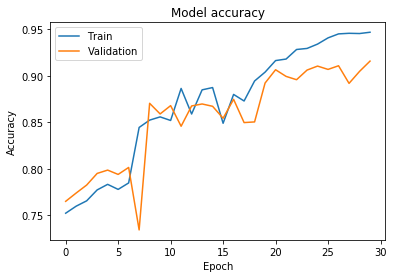

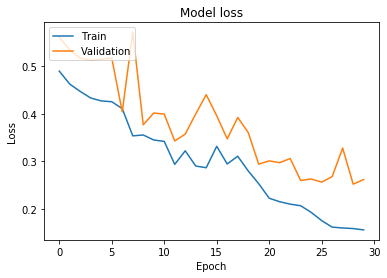

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Restore Weights

In [7]:
checkpoint_dir = './checkpoints/' + model_name
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [8]:
test_predict = model.predict(test_data.x)
print(test_predict.shape)

(6051, 1)




## Save Prediction to CSV

In [9]:
import csv

output_file = 'result_' + model_name + '.csv'
with open(output_file, 'wt', newline='', encoding='utf-8') as output_file:
    csv_writer = csv.writer(output_file)
    csv_writer.writerow(('Id', 'Predicted'))
    for id, predict in enumerate(test_predict):
        csv_writer.writerow((id, predict[0]))